# **Pump it Up: Data Mining the Water Table**




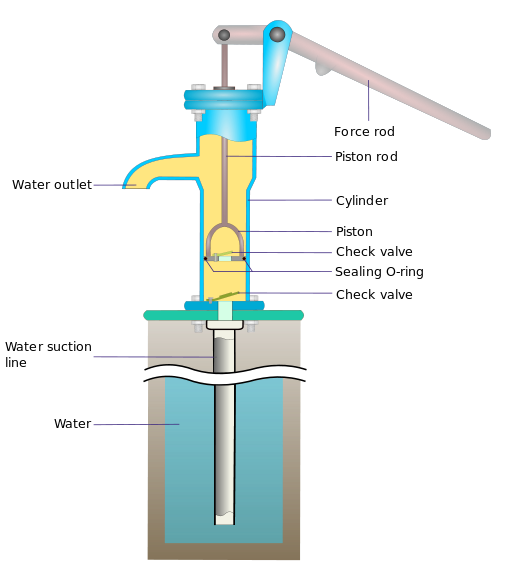

## **Introducción**
Este reto forma parte de [Driven Data Competition Pump it Up: Data Mining the Water Table](https://www.drivendata.org/competitions/7/pump-it-up-data-mining-the-water-table/), que utiliza datos de Taarifa y el Ministerio del Agua de Tanzania. La tarea consiste en buscar soluciones basadas en datos para predecir qué puntos de agua fallarán con el fin de mejorar las operaciones de mantenimiento y garantizar la disponibilidad de agua potable limpia para las comunidades de toda Tanzania.

La tarea es un problema de clasificación multiclase para predecir el estado de las bombas de agua en Tanzania en tres categorías: `funcionando`, `necesita reparación` y `falla`.

www.drivendata.org

##**Objetivo**
Haciendo uso de los datos cargados en la web de Taarifa y el Ministerio de Tanzania del Agua, nuestro objetivo es predecir qué bombas funcionan, cuáles no y cuáles necesitan una reparación. Entender cuáles fallarán es importante por los siguientes motivos:

Predecir la funcionalidad de todas las bombas de agua subterránea que se encuentran en el territorio con modelos precisos, podría ayudar a ahorrarle al gobierno de Tanzania mucho tiempo y dinero.
Estos modelos pueden ayudar a reducir el costo de inspección de cada bomba de agua.

El presente trabajo va a estar dividido en tres partes: siendo la primera el Análisis Exploratorio de los Datos, la segunda el Preprocesado de los mismos y la tercera la Selección del Modelo.

## **Importamos la librerías necesarias**

In [1]:
!pip install catboost # Category Boosting
!pip install category_encoders #  biblioteca para la transformación de características, principalmente para variables categóricas

In [2]:
from google.colab import files

import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
from matplotlib import pyplot
import seaborn as sns
from sklearn import preprocessing
import datetime as dt
from numpy import mean
from numpy import std


from sklearn.model_selection import train_test_split
from sklearn import metrics
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.impute import KNNImputer

# selección de características
from sklearn.feature_selection import mutual_info_classif
from sklearn.datasets import make_classification
from sklearn.feature_selection import SelectKBest
from sklearn.feature_selection import chi2
from sklearn.feature_selection import f_classif

# encoders
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import OrdinalEncoder
from sklearn.preprocessing import OneHotEncoder
import category_encoders as ce
from category_encoders import TargetEncoder

from sklearn.model_selection import train_test_split
from sklearn import metrics
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
from sklearn.model_selection import RepeatedStratifiedKFold
from sklearn.model_selection import cross_val_score

# clasificadores
from sklearn.ensemble import RandomForestClassifier, ExtraTreesClassifier, StackingClassifier, VotingClassifier, GradientBoostingClassifier
from xgboost.sklearn import XGBClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.neighbors import KNeighborsClassifier
from sklearn.neural_network import MLPClassifier
import lightgbm as lgb
from sklearn.linear_model import SGDClassifier
from sklearn.svm import SVC
from sklearn.linear_model import LogisticRegression
from catboost import CatBoostClassifier
from sklearn.ensemble import GradientBoostingRegressor
from sklearn import svm

# ajuste de hiperparámetros
from sklearn.model_selection import RandomizedSearchCV, GridSearchCV

from sklearn.decomposition import PCA
from matplotlib.pyplot import figure


import warnings
warnings.filterwarnings('ignore')

# **Análisis Exploratorio de los Datos**

###  Descripción de los datos
Comenzamos con una pequeña descripción de los datos con los que vamos a trabajar:

###  Características

* **amount_tsh** - Cantidad de agua para bombear
* **date_recorded** - Fecha de inserción de datos
* **funder** - Quién fundó el pozo
* **gps_height** - Altitud del pozo
* **installer** - Organización que lo instaló
* **longitude** - Coordenadas GPS
* **latitude** - Coordenadas GPS
* **wpt_name** - Nombre de la bomba (si es que lo tiene)
* **num_private** - Número
* **basin** - Cuenca geográfica
* **subvillage** - Localización geográfica
* **region** - Localización geográfica
* **region_code** - Localización geográfica (en código)
* **district_code** - Localización geográfica (en código)
* **lga** - Localización geográfica
* **ward** - Localización geográfica
* **population** - Población junto al pozo
* **public_meeting** - Verdadero/Falso
* **recorded_by** - Grupo que introduce estos datos
* **scheme_management** - Quién gestiona la bomba
* **scheme_name** - Quién maneja la bomba
* **permit** - Si la bomba está permitida o no
* **construction_year** - Año de construcción de la bomba
* **extraction_type** - Tipo de extracción de la bomba
* **extraction_type_group** - Tipo de extracción de la bomba
* **extraction_type_class** - Tipo de extracción de la bomba
* **management** - Cómo se gestiona la bomba
* **management_group** - Cómo se gestiona la bomba
* **payment** - Coste del agua
* **payment_type** - Coste del agua
* **water_quality** - Calidad del agua
* **quality_group** - Calidad del agua
* **quantity** - Cantidad de agua
* **quantity_group** - Cantidad de agua
* **source** - Fuente del agua
* **source_type** - Fuente del agua
* **source_class** - Fuente del agua
* **waterpoint_type** - Tipo de bomba
* **waterpoint_type_group** - Tipo de bomba

### **Etiquetas**
Las etiquetas en este dataset son simples. Hay tres valores posibles:

* **0 - functional** - *La bomba funciona y no es necesario repararla*
* **1 - non functional** - *La bomba de agua no funciona*
* **2 - functional needs repair** - *Funciona, pero necesita reparación*

### **Importamos los datos**

In [3]:
features_df = pd.read_csv(
    "https://raw.githubusercontent.com/carolProg/PROYECTO/main/training_set_values.csv",
    index_col="id",
    low_memory=False
)
labels_df = pd.read_csv(
    "https://raw.githubusercontent.com/carolProg/PROYECTO/main/training_set_labels.csv",
    index_col="id"
)
test_df = pd.read_csv(
    "https://raw.githubusercontent.com/carolProg/PROYECTO/main/test_set_values.csv",
    index_col="id",
    low_memory=False
)

In [4]:
print("# Train Values: {}".format(features_df.shape))
print("# Train Labels: {}".format(labels_df.shape))
print("# Test Values: {}".format(test_df.shape))

# Train Values: (59400, 39)
# Train Labels: (59400, 1)
# Test Values: (14850, 39)


In [5]:
labels_df.head()

,status_group
id,
69572,functional
8776,functional
34310,functional
67743,non functional
19728,functional


La variable objetivo es 'status_group' con tres valores posibles:

* 0  functional - La bomba funciona y no es necesario repararla
* 1  non functional - La bomba de agua no funciona
* 2  functional needs repair - Funciona, pero necesita reparación

In [6]:
features_df.head()

,amount_tsh,date_recorded,funder,gps_height,installer,longitude,latitude,wpt_name,num_private,basin,...,payment_type,water_quality,quality_group,quantity,quantity_group,source,source_type,source_class,waterpoint_type,waterpoint_type_group
id,,,,,,,,,,,,,,,,,,,,,
69572,6000.0,2011-03-14,Roman,1390,Roman,34.938093,-9.856322,none,0,Lake Nyasa,...,annually,soft,good,enough,enough,spring,spring,groundwater,communal standpipe,communal standpipe
8776,0.0,2013-03-06,Grumeti,1399,GRUMETI,34.698766,-2.147466,Zahanati,0,Lake Victoria,...,never pay,soft,good,insufficient,insufficient,rainwater harvesting,rainwater harvesting,surface,communal standpipe,communal standpipe
34310,25.0,2013-02-25,Lottery Club,686,World vision,37.460664,-3.821329,Kwa Mahundi,0,Pangani,...,per bucket,soft,good,enough,enough,dam,dam,surface,communal standpipe multiple,communal standpipe
67743,0.0,2013-01-28,Unicef,263,UNICEF,38.486161,-11.155298,Zahanati Ya Nanyumbu,0,Ruvuma / Southern Coast,...,never pay,soft,good,dry,dry,machine dbh,borehole,groundwater,communal standpipe multiple,communal standpipe
19728,0.0,2011-07-13,Action In A,0,Artisan,31.130847,-1.825359,Shuleni,0,Lake Victoria,...,never pay,soft,good,seasonal,seasonal,rainwater harvesting,rainwater harvesting,surface,communal standpipe,communal standpipe


### **Tipos de Datos**

In [7]:
features_df.dtypes

amount_tsh               float64
date_recorded             object
funder                    object
gps_height                 int64
installer                 object
longitude                float64
latitude                 float64
wpt_name                  object
num_private                int64
basin                     object
subvillage                object
region                    object
region_code                int64
district_code              int64
lga                       object
ward                      object
population                 int64
public_meeting            object
recorded_by               object
scheme_management         object
scheme_name               object
permit                    object
construction_year          int64
extraction_type           object
extraction_type_group     object
extraction_type_class     object
management                object
management_group          object
payment                   object
payment_type              object
water_qual

In [8]:
labels_df.dtypes

status_group    object
dtype: object

In [9]:
test_df.dtypes

amount_tsh               float64
date_recorded             object
funder                    object
gps_height                 int64
installer                 object
longitude                float64
latitude                 float64
wpt_name                  object
num_private                int64
basin                     object
subvillage                object
region                    object
region_code                int64
district_code              int64
lga                       object
ward                      object
population                 int64
public_meeting            object
recorded_by               object
scheme_management         object
scheme_name               object
permit                    object
construction_year          int64
extraction_type           object
extraction_type_group     object
extraction_type_class     object
management                object
management_group          object
payment                   object
payment_type              object
water_qual

In [10]:
labels_df.head()

,status_group
id,
69572,functional
8776,functional
34310,functional
67743,non functional
19728,functional


La variable objetivo es 'status_group' con tres valores posibles:

- 0 functional - La bomba funciona y no es necesario repararla
- 1 non functional - La bomba de agua no funciona
- 2 functional needs repair - Funciona, pero necesita reparación

In [11]:
# Buscamos las distribución de las etiquetas
labels_df.groupby(['status_group']).size()

status_group
functional                 32259
functional needs repair     4317
non functional             22824
dtype: int64

In [12]:
X = features_df.copy()
y = labels_df.copy()
X_test = test_df.copy()

In [13]:
X.info()

<class 'pandas.core.frame.DataFrame'>
Index: 59400 entries, 69572 to 26348
Data columns (total 39 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   amount_tsh             59400 non-null  float64
 1   date_recorded          59400 non-null  object 
 2   funder                 55763 non-null  object 
 3   gps_height             59400 non-null  int64  
 4   installer              55745 non-null  object 
 5   longitude              59400 non-null  float64
 6   latitude               59400 non-null  float64
 7   wpt_name               59398 non-null  object 
 8   num_private            59400 non-null  int64  
 9   basin                  59400 non-null  object 
 10  subvillage             59029 non-null  object 
 11  region                 59400 non-null  object 
 12  region_code            59400 non-null  int64  
 13  district_code          59400 non-null  int64  
 14  lga                    59400 non-null  object 
 15  war

### **Unimos el dataset train_values y train_labels antes de la limpieza de datos**

In [14]:
# Combinamos el dataset de entrenamiento con el dataset de pruebas
df = pd.concat([X, X_test], ignore_index=True)

In [15]:
#Descargo el dataframe obtenido para inspeccionarlo con POWERBI
with open('datos_train.csv', 'w') as f:
 df.to_csv(f,  index = False)

files.download('datos_train.csv')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [16]:
df.describe()

,amount_tsh,gps_height,longitude,latitude,num_private,region_code,district_code,population,construction_year
count,74250.000000,74250.000000,74250.000000,7.425000e+04,74250.000000,74250.000000,74250.000000,74250.000000,74250.000000
mean,318.685704,665.667313,34.074262,-5.701771e+00,0.462330,15.265414,5.629077,180.750828,1298.463650
std,2906.762364,692.761033,6.572519,2.944969e+00,11.537879,17.508907,9.641636,471.086120,952.349375
min,0.000000,-90.000000,0.000000,-1.164944e+01,0.000000,1.000000,0.000000,0.000000,0.000000
25%,0.000000,0.000000,33.086819,-8.525675e+00,0.000000,5.000000,2.000000,0.000000,0.000000
50%,0.000000,364.000000,34.907475,-5.026540e+00,0.000000,12.000000,3.000000,25.000000,1986.000000
75%,20.000000,1317.000000,37.181685,-3.325058e+00,0.000000,17.000000,5.000000,215.000000,2004.000000
max,350000.000000,2777.000000,40.345193,-2.000000e-08,1776.000000,99.000000,80.000000,30500.000000,2013.000000


In [17]:
y.head()

,status_group
id,
69572,functional
8776,functional
34310,functional
67743,non functional
19728,functional


### **Características numéricas**

In [18]:
numerical_vars = df.select_dtypes(exclude='object')
numeric_cols = numerical_vars.columns.tolist() # Columnas numéricas en el dataset
print(numeric_cols)

['amount_tsh', 'gps_height', 'longitude', 'latitude', 'num_private', 'region_code', 'district_code', 'population', 'construction_year']


#### **Distribución de variables numéricas**

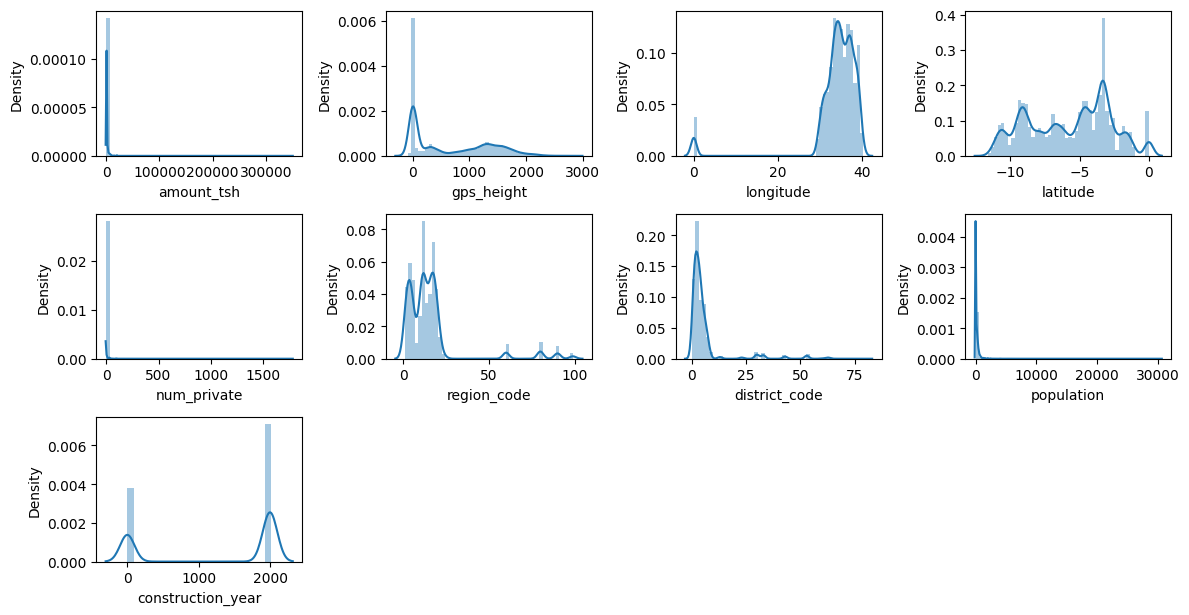

In [19]:
fig = plt.figure(figsize=(12,18))
sns.distributions._has_statsmodels=False
for i in range(len(numeric_cols)):
    fig.add_subplot(9,4,i+1)
    sns.distplot(df[numeric_cols].iloc[:,i].dropna())
    plt.xlabel(numeric_cols[i])

plt.tight_layout()
plt.show()

#### Análisis univariante: diagramas de caja para atributos numéricos

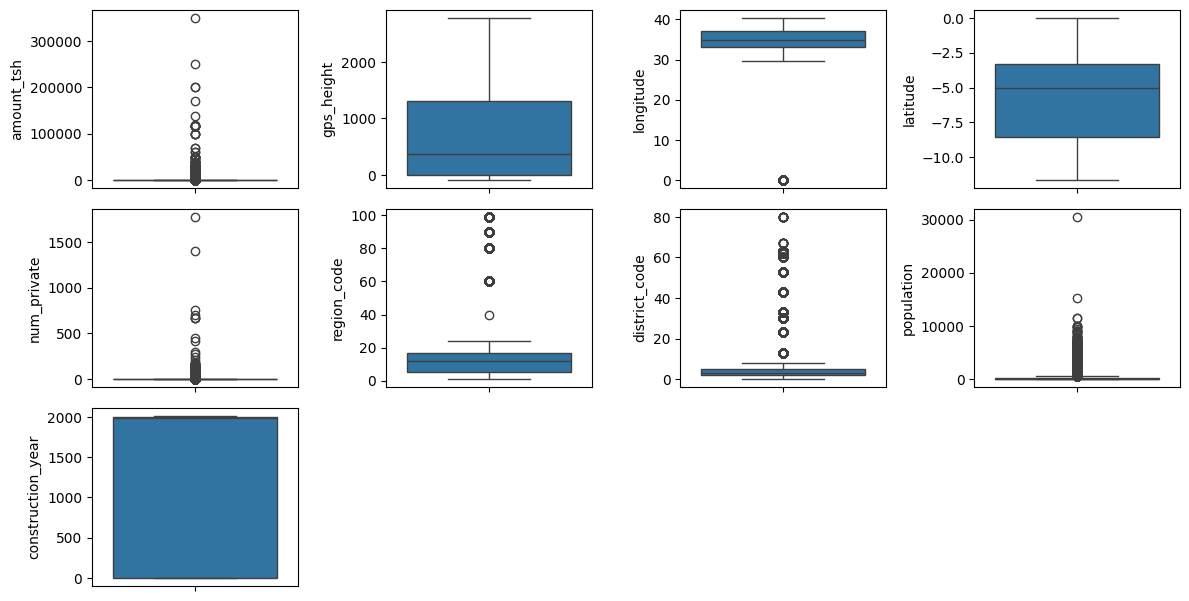

In [20]:
fig = plt.figure(figsize=(12, 18))

for i in range(len(numeric_cols)):
    fig.add_subplot(9, 4, i+1)
    sns.boxplot(y=df[numeric_cols].iloc[:,i])

plt.tight_layout()
plt.show()

### **Características categóricas**

In [21]:
cat_vars = df.select_dtypes(include='object')
object_cols = cat_vars.columns.tolist() # Columnas string en el dataset
print(object_cols)

['date_recorded', 'funder', 'installer', 'wpt_name', 'basin', 'subvillage', 'region', 'lga', 'ward', 'public_meeting', 'recorded_by', 'scheme_management', 'scheme_name', 'permit', 'extraction_type', 'extraction_type_group', 'extraction_type_class', 'management', 'management_group', 'payment', 'payment_type', 'water_quality', 'quality_group', 'quantity', 'quantity_group', 'source', 'source_type', 'source_class', 'waterpoint_type', 'waterpoint_type_group']


## **Limpieza de datos**

In [22]:
X.isnull().sum()

amount_tsh                   0
date_recorded                0
funder                    3637
gps_height                   0
installer                 3655
longitude                    0
latitude                     0
wpt_name                     2
num_private                  0
basin                        0
subvillage                 371
region                       0
region_code                  0
district_code                0
lga                          0
ward                         0
population                   0
public_meeting            3334
recorded_by                  0
scheme_management         3878
scheme_name              28810
permit                    3056
construction_year            0
extraction_type              0
extraction_type_group        0
extraction_type_class        0
management                   0
management_group             0
payment                      0
payment_type                 0
water_quality                0
quality_group                0
quantity

In [23]:
X_test.isnull().sum()

amount_tsh                  0
date_recorded               0
funder                    870
gps_height                  0
installer                 877
longitude                   0
latitude                    0
wpt_name                    0
num_private                 0
basin                       0
subvillage                 99
region                      0
region_code                 0
district_code               0
lga                         0
ward                        0
population                  0
public_meeting            821
recorded_by                 0
scheme_management         969
scheme_name              7242
permit                    737
construction_year           0
extraction_type             0
extraction_type_group       0
extraction_type_class       0
management                  0
management_group            0
payment                     0
payment_type                0
water_quality               0
quality_group               0
quantity                    0
quantity_g

In [24]:
X_null = X.isnull().sum()
test_null = X_test.isnull().sum()

In [25]:
# Obtenemos el listado de columnas desde train_values
list_features = X_test.columns

# Imprimimos el número de características
print(f'Number of features: {len(list_features)}\n')

# Iteramos sobre cada característica para mostrar los detalles
for i, feature in enumerate(list_features):

    # Calculamos el porcentaje de valores perdidos para cada columna en los datasets de entrenamiento y prueba
    missing_train_percent = (X_null[feature] / X.shape[0]) * 100
    missing_test_percent = (test_null[feature] / X.shape[0]) * 100

    # Imprimimos los datalles de cada característica
    print(f'Feature: {feature} || Type: {type(X[feature].iloc[0])} || '
          f'Example: {X[feature].iloc[0]} || Number of unique values: {X[feature].nunique()} || '
          f'Missing values training: {missing_train_percent}% || Missing values test: {missing_test_percent}%')

Number of features: 39

Feature: amount_tsh || Type: <class 'numpy.float64'> || Example: 6000.0 || Number of unique values: 98 || Missing values training: 0.0% || Missing values test: 0.0%
Feature: date_recorded || Type: <class 'str'> || Example: 2011-03-14 || Number of unique values: 356 || Missing values training: 0.0% || Missing values test: 0.0%
Feature: funder || Type: <class 'str'> || Example: Roman || Number of unique values: 1896 || Missing values training: 6.122895622895623% || Missing values test: 1.4646464646464648%
Feature: gps_height || Type: <class 'numpy.int64'> || Example: 1390 || Number of unique values: 2428 || Missing values training: 0.0% || Missing values test: 0.0%
Feature: installer || Type: <class 'str'> || Example: Roman || Number of unique values: 2145 || Missing values training: 6.153198653198653% || Missing values test: 1.4764309764309764%
Feature: longitude || Type: <class 'numpy.float64'> || Example: 34.93809275 || Number of unique values: 57516 || Missing

In [26]:
# Calculamos el número total de filas en el DataFrame
all_rows = X.shape[0]

# Calculamos el número de valores cero en cada columna
X_zero = (X == 0).sum()

# Obtenermos el listado de nombres de columnas
list_X = X_test.columns

# Imprimimos el número de características
print(f'Number of features: {len(list_X)}\n')

# Iteramos sobre cada columna para calcular e imprimir el porcentaje 0
for feature in list_X:
    zero_percentage = (X_zero[feature] / all_rows) * 100

    # Solamente imprimimos las columnas donde el porcentaje es mayor que 0
    if zero_percentage > 0:
        example_value = X[feature].iloc[0]
        print(f'Feature: {feature} || Type: {type(example_value)} || '
              f'Example: {example_value} || Zero percentage: {zero_percentage:.2f}%')

Number of features: 39

Feature: amount_tsh || Type: <class 'numpy.float64'> || Example: 6000.0 || Zero percentage: 70.10%
Feature: gps_height || Type: <class 'numpy.int64'> || Example: 1390 || Zero percentage: 34.41%
Feature: longitude || Type: <class 'numpy.float64'> || Example: 34.93809275 || Zero percentage: 3.05%
Feature: num_private || Type: <class 'numpy.int64'> || Example: 0 || Zero percentage: 98.73%
Feature: district_code || Type: <class 'numpy.int64'> || Example: 5 || Zero percentage: 0.04%
Feature: population || Type: <class 'numpy.int64'> || Example: 109 || Zero percentage: 35.99%
Feature: public_meeting || Type: <class 'bool'> || Example: True || Zero percentage: 8.51%
Feature: permit || Type: <class 'bool'> || Example: False || Zero percentage: 29.45%
Feature: construction_year || Type: <class 'numpy.int64'> || Example: 1999 || Zero percentage: 34.86%


In [27]:
# Eliminamos la columna con mayor cantidad de valores perdidos, ceros y más valores únicos
df.drop(columns=['num_private', 'scheme_name'], axis=1, inplace=True)

In [28]:
# Eliminamos la columna recorded_by porque sólo hay una institución grabando y la columna wpt_name porque tiene demasiados valores Nan
df.drop(columns=['recorded_by','wpt_name'], axis=1, inplace=True)

### **Manejo de valores perdidos**

In [29]:
# Número de valores perdidos en cada columna
missing_val_count_by_column = (df.isnull().sum())
print(missing_val_count_by_column[missing_val_count_by_column > 0])

funder               4507
installer            4532
subvillage            470
public_meeting       4155
scheme_management    4847
permit               3793
dtype: int64


*   population - rellenamos ceros con nan y la moda
*   funder - rellenamos ceros con la moda
*   installer - rellenamos ceros con la moda
*   subvilage - rellenamos ceros con la moda
*   public_meeting - rellenamos ceros con la moda
*   scheme_management - rellenamos ceros con la moda
*   permit - rellenamos ceros con la moda
*   construction year - rellenamos ceros con nan y la moda









In [30]:
missing_columns = ['construction_year','population']
for col in missing_columns:
  df[col].replace(0, np.nan, inplace=True)

In [31]:
all_rows = df.shape[0]  # Total de filas en el DataFrame

# Convierte datos a booleanos para identificar los ceros y suma en el eje 0 (columnas)
X_zero = (df == 0).sum()

# Obtiene la lista de columnas del DataFrame
list_X = df.columns

# Imprime el número de características
print(f'Número de características: {len(list_X)}\n')

# Itera sobre cada columna para calcular el porcentaje de ceros
for feature in list_X:
    zero_percentage = (X_zero[feature] / all_rows) * 100
    if zero_percentage > 0:
        example_value = df[feature].iloc[0]  # Ejemplo de valor en la columna
        print(f'Característica: {feature} || Tipo: {type(example_value)} || '
              f'Ejemplo: {example_value} || Porcentaje de ceros: {zero_percentage:.2f}%')

Número de características: 35

Característica: amount_tsh || Tipo: <class 'numpy.float64'> || Ejemplo: 6000.0 || Porcentaje de ceros: 70.10%
Característica: gps_height || Tipo: <class 'numpy.int64'> || Ejemplo: 1390 || Porcentaje de ceros: 34.54%
Característica: longitude || Tipo: <class 'numpy.float64'> || Ejemplo: 34.93809275 || Porcentaje de ceros: 3.06%
Característica: district_code || Tipo: <class 'numpy.int64'> || Ejemplo: 5 || Porcentaje de ceros: 0.04%
Característica: public_meeting || Tipo: <class 'bool'> || Ejemplo: True || Porcentaje de ceros: 8.55%
Característica: permit || Tipo: <class 'bool'> || Ejemplo: False || Porcentaje de ceros: 29.43%


In [32]:
# Creamos la función rellenar_moda para rellenar los valores perdidos con la moda
# se refiere a una técnica de imputación de datos usada para manejar valores faltantes en un conjunto de datos.
# Esta técnica implica reemplazar los valores faltantes en una columna o variable con el valor que más
# frecuentemente aparece en esa columna, conocido como la moda.

def rellenar_moda(all_column, X):
  for X_column in X:
    X[X_column] = X[X_column].fillna(X[X_column].mode()[0])
  return X

In [33]:
# Rellenamos las columnas con el valor de la moda
df = rellenar_moda(["funder","installer","subvillage","public_meeting","scheme_management","permit","construction_year"],df)

In [34]:
# Para la columna de población rellenamos los valores faltantes con la media
def rellenar_media(all_column, X):
  for X_column in all_column:
    X[X_column] = X[X_column].fillna(round(X[X_column].mean()))
  return X

In [35]:
df = rellenar_media(["population"], df)

In [36]:
# Comprobamos el número de valores faltantes en cada columna
# Vemos que no hay valores faltantes
missing_val_count_by_column = (df.isnull().sum())
print(missing_val_count_by_column[missing_val_count_by_column > 0])

Series([], dtype: int64)


*   *No quedan valores perdidos*

### **Visualización de datos**

In [37]:
# Combinamos el dataset de entrenamiento con las etiquetas
combined = df.copy()
# añadimos una nueva columna llamada status_group al DataFrame combined. Los valores para esta columna provienen del DataFrame y(etiquetas), específicamente de una columna también denominada status_group en y.
combined['status_group'] = y['status_group']

In [38]:
combined.head()

,amount_tsh,date_recorded,funder,gps_height,installer,longitude,latitude,basin,subvillage,region,...,water_quality,quality_group,quantity,quantity_group,source,source_type,source_class,waterpoint_type,waterpoint_type_group,status_group
0,6000.0,2011-03-14,Roman,1390,Roman,34.938093,-9.856322,Lake Nyasa,Mnyusi B,Iringa,...,soft,good,enough,enough,spring,spring,groundwater,communal standpipe,communal standpipe,non functional
1,0.0,2013-03-06,Grumeti,1399,GRUMETI,34.698766,-2.147466,Lake Victoria,Nyamara,Mara,...,soft,good,insufficient,insufficient,rainwater harvesting,rainwater harvesting,surface,communal standpipe,communal standpipe,functional
2,25.0,2013-02-25,Lottery Club,686,World vision,37.460664,-3.821329,Pangani,Majengo,Manyara,...,soft,good,enough,enough,dam,dam,surface,communal standpipe multiple,communal standpipe,functional
3,0.0,2013-01-28,Unicef,263,UNICEF,38.486161,-11.155298,Ruvuma / Southern Coast,Mahakamani,Mtwara,...,soft,good,dry,dry,machine dbh,borehole,groundwater,communal standpipe multiple,communal standpipe,functional
4,0.0,2011-07-13,Action In A,0,Artisan,31.130847,-1.825359,Lake Victoria,Kyanyamisa,Kagera,...,soft,good,seasonal,seasonal,rainwater harvesting,rainwater harvesting,surface,communal standpipe,communal standpipe,non functional


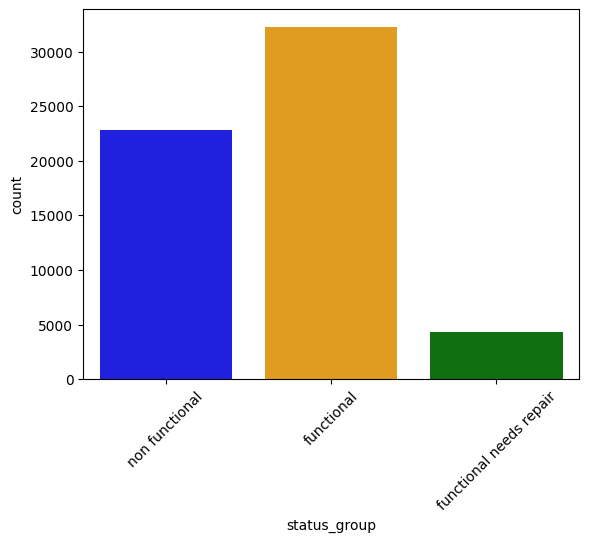

In [39]:
# La variable objetivo es 'status_group'
colores = ['blue', 'orange', 'green']

sns.countplot(x='status_group', data=combined, palette=colores)
plt.xticks(rotation=45)
plt.show()

Del gráfico anterior, es fácil ver que nuestro conjunto de datos está desbalanceado. Es importante mencionar que los árboles de decisión y los bosques aleatorios son extremadamente sensibles a los datos desequilibrados por lo que trataremos este problema más adelante.

In [40]:
combined['status_group'].unique()

array(['non functional', 'functional', nan, 'functional needs repair'],
      dtype=object)

**Amount_tsh**

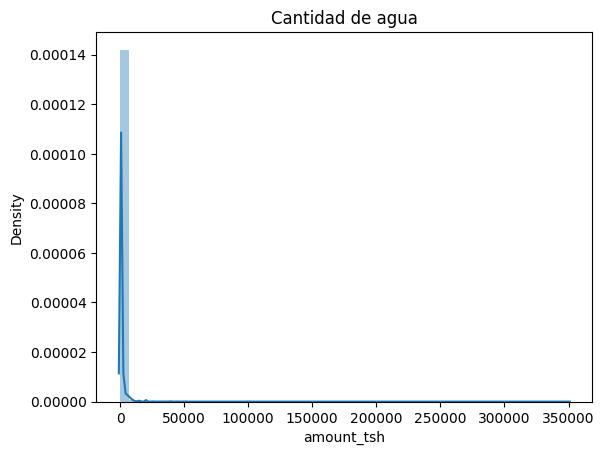

In [41]:
fig = sns.distplot(df['amount_tsh'])
plt.title('Cantidad de agua')
plt.show(fig)

In [42]:
# La transformación logarítmica se usa en el análisis de datos para tratar con variables
# que contienen valores altamente sesgados o distribuciones que están lejos de ser normales,
# ya que ayuda a estabilizar la varianza y a normalizar la distribución de los datos.
# Esta línea transforma los valores de la columna amount_tsh aplicando el logaritmo natural.
# Se le suma 1 al valor antes de tomar el logaritmo para evitar el error matemático que se produciría al tomar el logaritmo de cero.

df['amt'] = np.log(df['amount_tsh']+1)

# El resultado de la transformación logarítmica se almacena en una nueva columna del DataFrame llamada amt.
# Esto permite conservar tanto los valores originales en amount_tsh como los transformados en amt, facilitando comparaciones y análisis posteriores.

In [43]:
# Creamos una nueva columna llamada amt_q3 en el DataFrame df. Inicialmente, todos los valores en esta columna se establecen en 0.
# Luego, para aquellos registros donde el valor en la columna amt es mayor que 3.044, se actualiza el valor en amt_q3 a 1.

df['amt_q3'] = 0
df.loc[(df['amt'] > 3.044), 'amt_q3'] = 1

# Esta es una forma de categorización binaria donde los valores se dividen en dos grupos según un umbral (en este caso, 3.044).
# Esto puede ser útil para separar los datos en "alto" y "bajo" basado en el valor logarítmico, facilitando análisis o modelados
# subsiguientes que dependen de categorías discretas en lugar de un espectro continuo de números.

In [44]:
# Contamos la cantidad de veces que aparecen los valores 0 y 1 en la columna amt_q3.
df.loc[:, 'amt_q3'].value_counts()

amt_q3
0    53880
1    20370
Name: count, dtype: int64

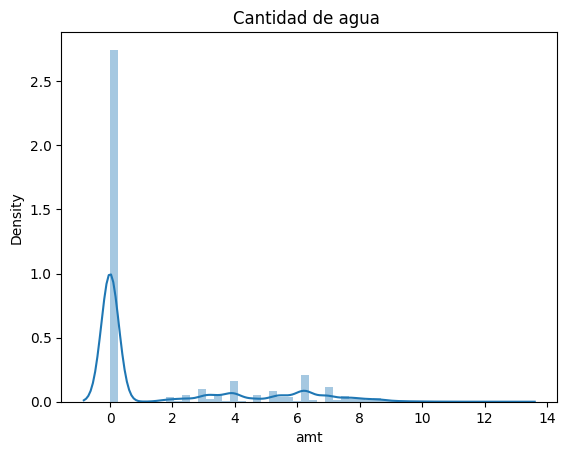

In [45]:
# Representamos 'amt'
fig = sns.distplot(df['amt'])
plt.title('Cantidad de agua ')
plt.show(fig)

In [46]:
# Borramos las columnas
df.drop(columns=['amount_tsh','amt_q3'], axis=1, inplace=True)

In [47]:
df['amt'].describe()

count    74250.000000
mean         1.586515
std          2.638600
min          0.000000
25%          0.000000
50%          0.000000
75%          3.044522
max         12.765691
Name: amt, dtype: float64

In [48]:
# Combinamos el dataset de entrenamiento con el dataset de las etiquetas
combined = df.copy()
combined['status_group'] = y['status_group']

<Axes: xlabel='status_group', ylabel='amt'>

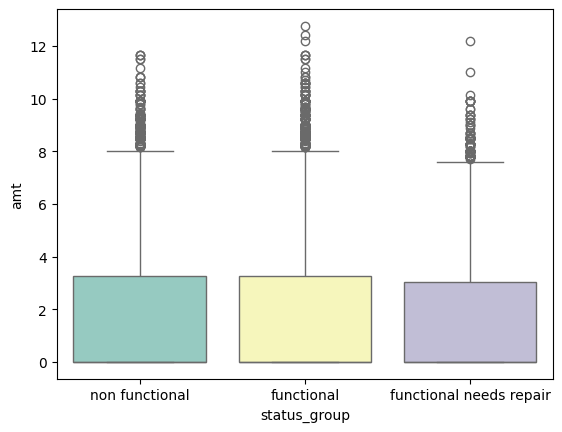

In [49]:
sns.boxplot(x="status_group", y="amt", data=combined, palette='Set3')

**Extraction**

In [50]:
# Seleccionamos las columnas 'extraction_type', 'extraction_type_group','extraction_type_class'
df_ex = df.loc[:, ['extraction_type', 'extraction_type_group','extraction_type_class']]

In [51]:
# Conteo de valores únicos de las tres columnas
df_ex.value_counts()

extraction_type            extraction_type_group  extraction_type_class
gravity                    gravity                gravity                  33263
nira/tanira                nira/tanira            handpump                 10205
other                      other                  other                     8102
submersible                submersible            submersible               5982
swn 80                     swn 80                 handpump                  4588
mono                       mono                   motorpump                 3628
india mark ii              india mark ii          handpump                  3029
afridev                    afridev                handpump                  2208
ksb                        submersible            submersible               1790
other - rope pump          rope pump              rope pump                  572
other - swn 81             other handpump         handpump                   284
windmill                   wind-power

In [52]:
# Conteo de valores únicos en la columna 'extraction_type_class'
df['extraction_type_class'].value_counts()

extraction_type_class
gravity         33263
handpump        20612
other            8102
submersible      7772
motorpump        3777
rope pump         572
wind-powered      152
Name: count, dtype: int64

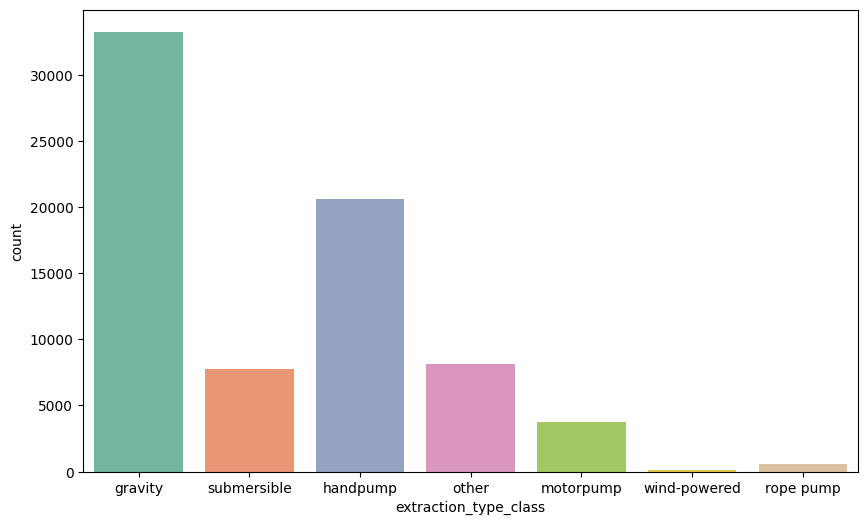

In [53]:
# Ajustar el tamaño del gráfico
plt.figure(figsize=(10, 6))

# Crear un countplot con barras de colores distintos
sns.countplot(x="extraction_type_class", data=combined, palette='Set2')

# Mostrar el gráfico
plt.show()


**Management Feature**

<Axes: xlabel='management_group', ylabel='count'>

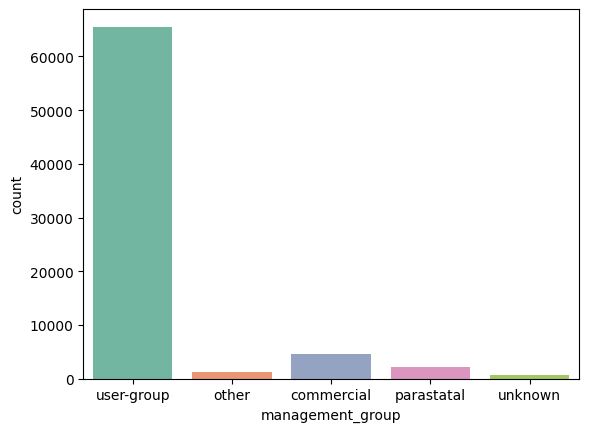

In [54]:
sns.countplot(x="management_group", data=combined, palette='Set2')

In [55]:
df["management_group"].value_counts()

management_group
user-group    65538
commercial     4591
parastatal     2229
other          1209
unknown         683
Name: count, dtype: int64

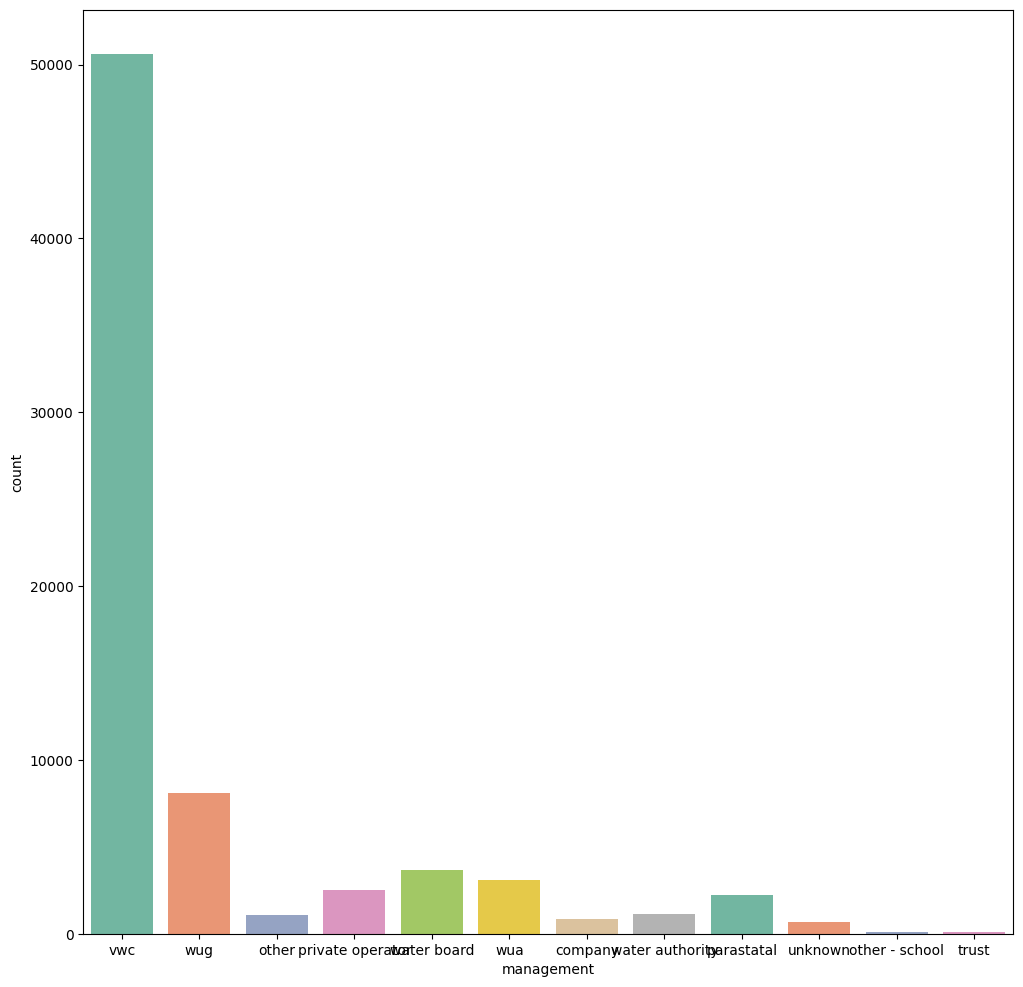

In [56]:
# Ajustar el tamaño del gráfico
plt.figure(figsize=(12, 12))

# Crear un countplot con barras de colores distintos
sns.countplot(x="management", data=combined, palette='Set2')

# Mostrar el gráfico
plt.show()


In [57]:
df["management"].value_counts()

management
vwc                 50624
wug                  8108
water board          3688
wua                  3118
private operator     2504
parastatal           2229
water authority      1123
other                1083
company               859
unknown               683
other - school        126
trust                 105
Name: count, dtype: int64

In [58]:
df_man = df.loc[:, ['management_group', 'management']]

In [59]:
df_man.value_counts()

management_group  management      
user-group        vwc                 50624
                  wug                  8108
                  water board          3688
                  wua                  3118
commercial        private operator     2504
parastatal        parastatal           2229
commercial        water authority      1123
other             other                1083
commercial        company               859
unknown           unknown               683
other             other - school        126
commercial        trust                 105
Name: count, dtype: int64

**Payment Feature**

In [60]:
df_pay = df.loc[:, ['payment', 'payment_type']]

In [61]:
df_pay.value_counts()

payment                payment_type
never pay              never pay       31712
pay per bucket         per bucket      11266
pay monthly            monthly         10397
unknown                unknown         10149
pay when scheme fails  on failure       4842
pay annually           annually         4570
other                  other            1314
Name: count, dtype: int64

In [62]:
df["payment"].value_counts()

payment
never pay                31712
pay per bucket           11266
pay monthly              10397
unknown                  10149
pay when scheme fails     4842
pay annually              4570
other                     1314
Name: count, dtype: int64

In [63]:
df["payment_type"].value_counts()

payment_type
never pay     31712
per bucket    11266
monthly       10397
unknown       10149
on failure     4842
annually       4570
other          1314
Name: count, dtype: int64

**Quality**

In [64]:
df_quality = df.loc[:, ['water_quality', 'quality_group']]

In [65]:
df_quality.value_counts()

water_quality       quality_group
soft                good             63505
salty               salty             6082
unknown             unknown           2345
milky               milky             1005
coloured            colored            623
salty abandoned     salty              423
fluoride            fluoride           244
fluoride abandoned  fluoride            23
Name: count, dtype: int64

**Quantity**

In [66]:
df_quantity = df.loc[:, ['quantity', 'quantity_group']]

In [67]:
df_quantity.value_counts()

quantity      quantity_group
enough        enough            41522
insufficient  insufficient      18896
dry           dry                7782
seasonal      seasonal           5075
unknown       unknown             975
Name: count, dtype: int64

**Source**

In [68]:
df_source = df.loc[:, ['source', 'source_type']]

In [69]:
df_source.value_counts()

source                source_type         
spring                spring                  21216
shallow well          shallow well            21140
machine dbh           borehole                13822
river                 river/lake              11964
rainwater harvesting  rainwater harvesting     2863
hand dtw              borehole                 1108
lake                  river/lake                950
dam                   dam                       840
other                 other                     261
unknown               other                      86
Name: count, dtype: int64

**Water Point**

In [70]:
df_water = df.loc[:, ['waterpoint_type', 'waterpoint_type_group']]

In [71]:
df_water.value_counts()

waterpoint_type              waterpoint_type_group
communal standpipe           communal standpipe       35628
hand pump                    hand pump                21884
other                        other                     8010
communal standpipe multiple  communal standpipe        7611
improved spring              improved spring            959
cattle trough                cattle trough              150
dam                          dam                          8
Name: count, dtype: int64

**District code**

<Axes: xlabel='district_code'>

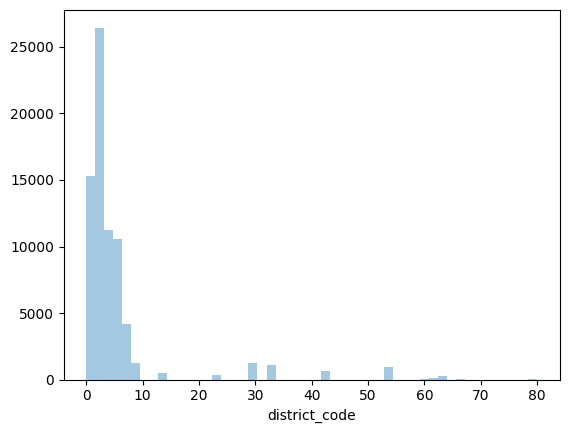

In [72]:
sns.distplot( combined['district_code'], kde=False)

**Public meeting**

<Axes: xlabel='public_meeting', ylabel='count'>

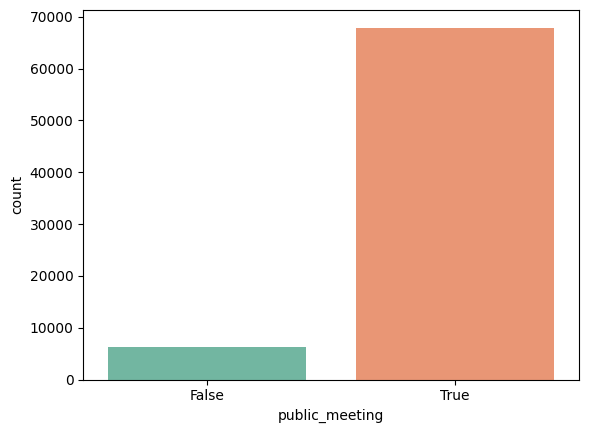

In [73]:
#Public meeting
sns.countplot(x="public_meeting", data=df, palette='Set2')

**Permit**

<Axes: xlabel='permit', ylabel='count'>

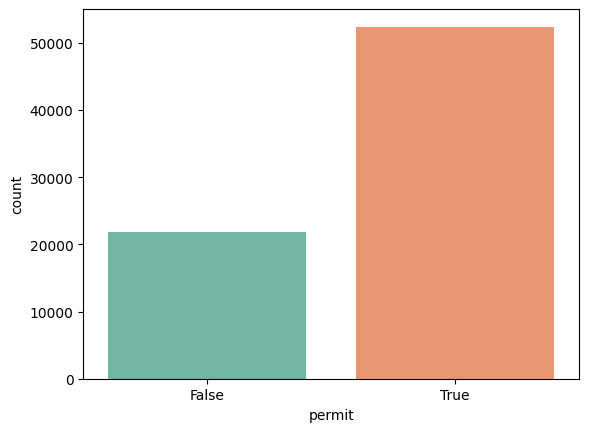

In [74]:
#Permit
sns.countplot(x="permit", data=combined, palette='Set2')

**Source class**

<Axes: xlabel='source_class', ylabel='count'>

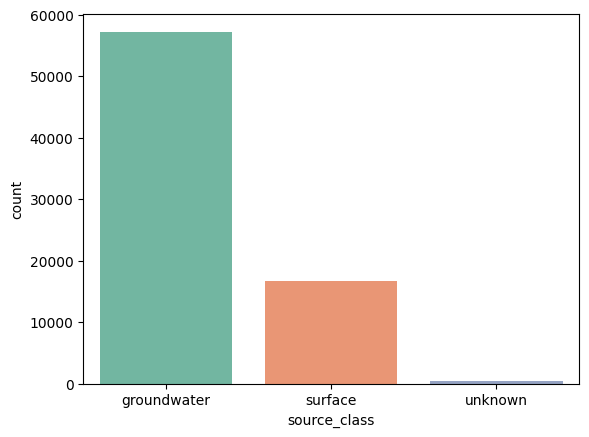

In [75]:
#source_class
sns.countplot(x="source_class", data=combined, palette='Set2')

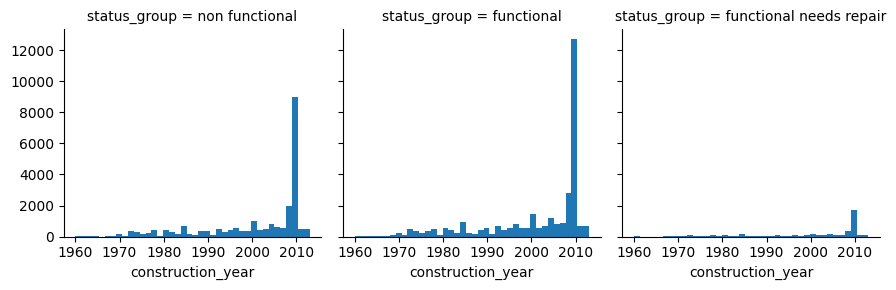

In [76]:
com  = df.copy()
com['status_group'] = y['status_group']
num = sns.FacetGrid(com, col='status_group')
print(num.map(plt.hist, 'construction_year', bins=40))

**Population**

In [77]:
df['population'].describe()

count    74250.000000
mean       181.112229
std        470.947677
min          1.000000
25%          1.000000
50%         25.000000
75%        215.000000
max      30500.000000
Name: population, dtype: float64

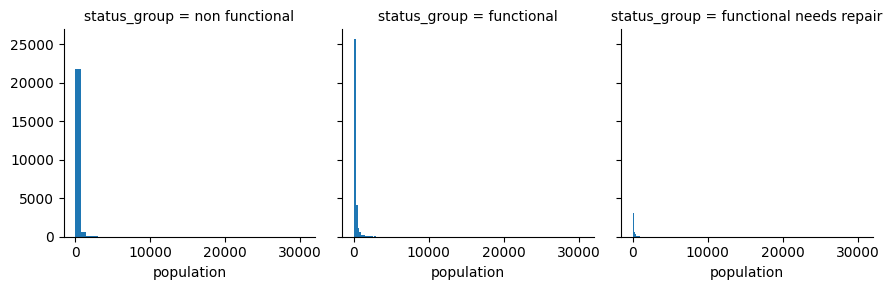

In [78]:
com  = df.copy()
com['status_group'] = y['status_group']
num = sns.FacetGrid(com, col='status_group')
print(num.map(plt.hist, 'population', bins=40))

<Axes: xlabel='status_group', ylabel='population'>

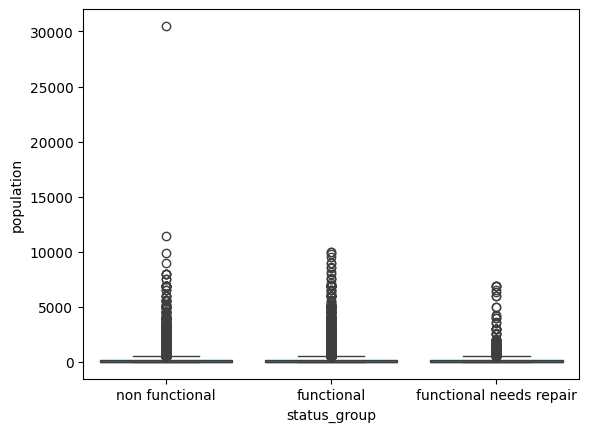

In [79]:
sns.boxplot(x="status_group", y="population",data= combined)

### **Matriz de Correlación**

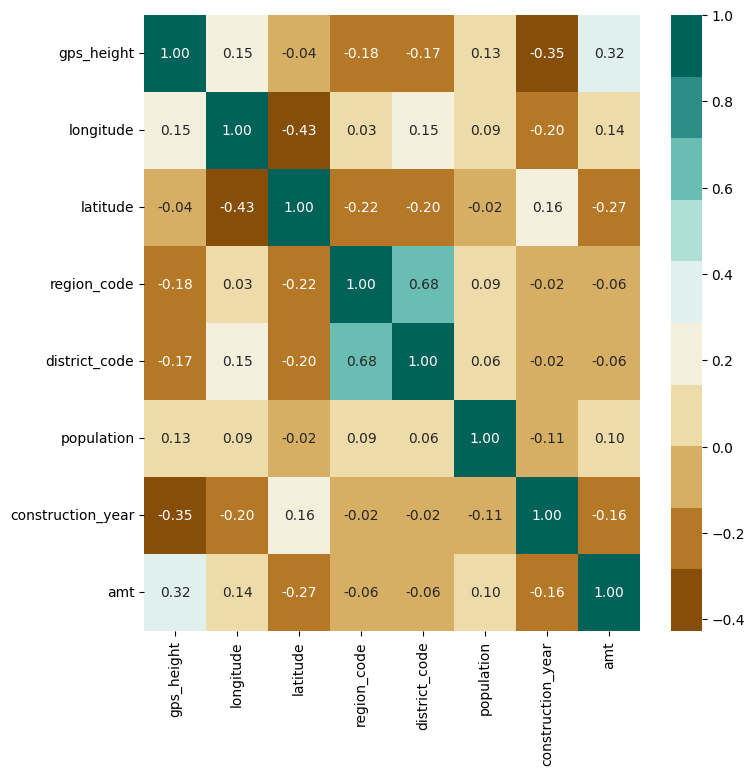

In [80]:
# Select only numeric columns for correlation matrix
numeric_cols = combined.select_dtypes(include=[np.number])  # This assumes you have imported numpy as np

# Compute the correlation matrix
corr_matrix = numeric_cols.corr()

# Plot correlation heatmap
fig, ax = plt.subplots(figsize=(8, 8))
colormap = sns.color_palette("BrBG", 10)
sns.heatmap(corr_matrix, cmap=colormap, annot=True, fmt=".2f")
plt.show()

**Region**

In [81]:
df_region = df.loc[:, ['region', 'region_code']]

In [82]:
df_region.value_counts()

region         region_code
Iringa         11             6599
Shinyanga      17             6262
Mbeya          12             5758
Kilimanjaro    3              5494
Morogoro       5              5038
Kagera         18             4174
Mwanza         19             3824
Arusha         2              3709
Kigoma         16             3533
Ruvuma         10             3306
Tanga          4              3145
Dodoma         1              2779
Singida        13             2536
Tabora         14             2466
Mara           20             2451
Rukwa          15             2242
Pwani          6              2032
Manyara        21             1972
Lindi          80             1536
Pwani          60             1298
Mtwara         90             1133
Dar es Salaam  7              1020
Mtwara         99              512
               9               499
Arusha         24              402
Lindi          8               375
Mwanza         17               72
Tanga          5            

In [83]:
df['region'].value_counts().nunique()

21

In [84]:
df['region_code'].value_counts().nunique()

27

In [85]:
df.head()

,date_recorded,funder,gps_height,installer,longitude,latitude,basin,subvillage,region,region_code,...,water_quality,quality_group,quantity,quantity_group,source,source_type,source_class,waterpoint_type,waterpoint_type_group,amt
0,2011-03-14,Roman,1390,Roman,34.938093,-9.856322,Lake Nyasa,Mnyusi B,Iringa,11,...,soft,good,enough,enough,spring,spring,groundwater,communal standpipe,communal standpipe,8.699681
1,2013-03-06,Grumeti,1399,GRUMETI,34.698766,-2.147466,Lake Victoria,Nyamara,Mara,20,...,soft,good,insufficient,insufficient,rainwater harvesting,rainwater harvesting,surface,communal standpipe,communal standpipe,0.000000
2,2013-02-25,Lottery Club,686,World vision,37.460664,-3.821329,Pangani,Majengo,Manyara,21,...,soft,good,enough,enough,dam,dam,surface,communal standpipe multiple,communal standpipe,3.258097
3,2013-01-28,Unicef,263,UNICEF,38.486161,-11.155298,Ruvuma / Southern Coast,Mahakamani,Mtwara,90,...,soft,good,dry,dry,machine dbh,borehole,groundwater,communal standpipe multiple,communal standpipe,0.000000
4,2011-07-13,Action In A,0,Artisan,31.130847,-1.825359,Lake Victoria,Kyanyamisa,Kagera,18,...,soft,good,seasonal,seasonal,rainwater harvesting,rainwater harvesting,surface,communal standpipe,communal standpipe,0.000000


#**Selección de características**
Los *puntajes de información mutua (MI Scores)* son una forma de medir la dependencia mutua entre dos variables. Este método es comúnmente utilizado en estadística y aprendizaje automático para determinar cuánta información comparten dos variables, lo que puede ser útil para la selección de características en modelos de datos.

Definimos la función llamada *make_mi_scores*, que calcula los puntajes de información mutua (MI Scores) entre cada característica en un conjunto de datos (features_df) y las etiquetas de clasificación (labels_df). Los puntajes de información mutua indican cuánta información sobre la variable objetivo puede obtenerse observando una característica, lo cual es especialmente útil para la selección de características en modelos de aprendizaje automático.

Este cálculo es útil en el contexto de aprendizaje automático para determinar qué características tienen la mayor dependencia mutua con las etiquetas, lo que puede ser un indicativo de su relevancia para un modelo de predicción

In [86]:
def make_mi_scores(features_df, labels_df):
  # Se crean copias de los conjuntos de datos de entrada para evitar modificar los datos originales
  # durante el proceso de manipulación y cálculo de los MI scores.
    features_df_mi = features_df.copy()
    labels_df_mi = labels_df.copy()

    # Codificación de Variables Categóricas
    # Se itera sobre cada columna de tipo object o category en features_df_mi y se usa la función factorize()
    # para convertir estas variables categóricas en representaciones numéricas.
    # Esto es necesario porque muchos algoritmos de aprendizaje automático y funciones estadísticas
    # requieren que las entradas sean numéricas.
    for colname in features_df_mi.select_dtypes(["object", "category"]):
        features_df_mi[colname], _ = features_df_mi[colname].factorize()

   # Manejo de Valores Faltantes:
   # Los valores faltantes en el conjunto de datos se reemplazan con -1. Este paso asegura que no haya valores NaN
   # que puedan causar errores durante el cálculo de los puntajes de información mutua.
    features_df_mi = features_df_mi.fillna(-1)

    # Identificación de Características Discretas
    # Todas las características discretas deben convertirse a tipos integer
    discrete_features = [pd.api.types.is_integer_dtype(t) for t in features_df_mi.dtypes]

    # Cálculo de los Puntajes de Información Mutua:
    # Utiliza la función mutual_info_classif de sklearn.feature_selection para calcular los puntajes de información mutua.
    # Esta función está diseñada específicamente para la selección de características en problemas de clasificación.
    # El argumento discrete_features indica cuáles características se deben tratar como discretas, y random_state se
    # establece para garantizar reproducibilidad.
    mi_scores = mutual_info_classif(features_df_mi, labels_df_mi, discrete_features=discrete_features, random_state=0)

    # Organización y Presentación de los Resultados
    # Los resultados se convierten en una serie de pandas con el nombre "MI Scores" y se indexan por el nombre
    # de las columnas de las características.
    # Luego, los puntajes se ordenan en orden descendente, poniendo las características más informativas en la parte superior de la lista.
    mi_scores = pd.Series(mi_scores, name="MI Scores", index=features_df_mi.columns)
    mi_scores = mi_scores.sort_values(ascending=False)
    return mi_scores

In [87]:
# Esta función visualiza las puntuaciones de información mutua de diferentes variables
# en forma de un gráfico de barras horizontal, con las variables ordenadas de menor a mayor puntuación de MI.
# Es útil para evaluar qué variables tienen mayor impacto o relación mutua con una variable objetivo en modelos de machine learning.
def plot_mi_scores(scores):
    scores = scores.sort_values(ascending=True)
    width = np.arange(len(scores))
    ticks = list(scores.index)
    plt.barh(width, scores)
    plt.yticks(width, ticks)
    plt.title("Mutual Information Scores")

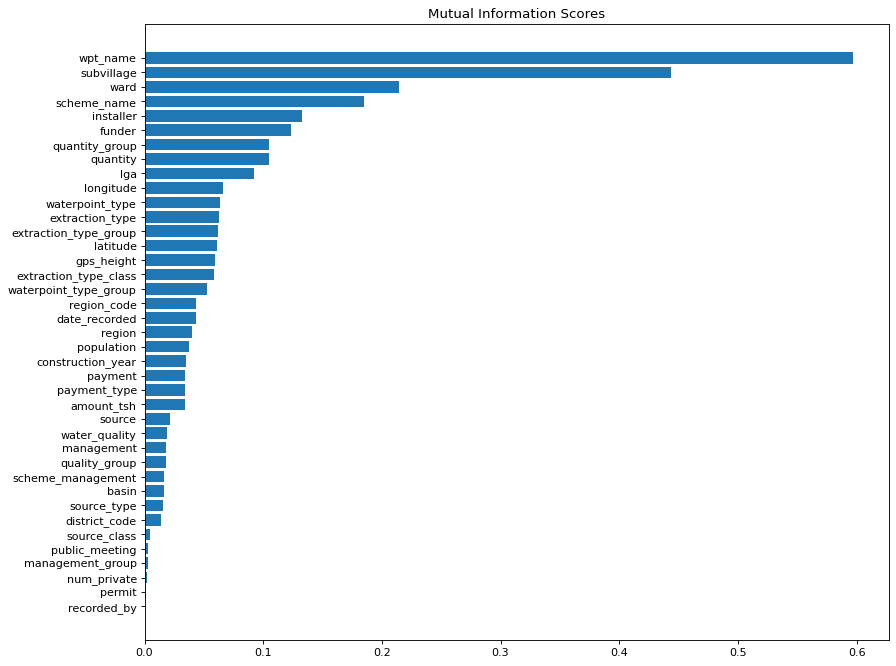

In [88]:
mi_scores = make_mi_scores(features_df, labels_df)
plt.figure(dpi=80, figsize=(12, 10))
plot_mi_scores(mi_scores.head(40))

In [89]:
X_sel = features_df.copy()
y_sel = labels_df.copy()

# Factorización de las características

# factorize() es un método de pandas que convierte una variable categórica en una representación numérica.
# Este método retorna dos objetos: un array con los valores factorizados y un índice que es la correspondencia única de los valores originales a los valores factorizados.
# Uso: La factorización es esencial para modelos de aprendizaje automático que requieren que todas las entradas sean numéricas.
# Al iterar sobre cada columna de X_sel, este código transforma todas las columnas categóricas en formatos numéricos, lo cual facilita su procesamiento por algoritmos de machine learning.

for colname in X_sel:
        X_sel[colname], _ = X_sel[colname].factorize()

# Manejo de valores faltantes
# fillna() es un método que rellena los valores NaN (valores faltantes) en un DataFrame.
# Se reemplazan todos los valores faltantes por -1. Este es un enfoque común cuando los modelos de machine learning que se usarán no pueden manejar valores NaN.
# El uso de -1 es particularmente útil si los valores numéricos no incluyen negativos, ya que claramente diferencia los valores faltantes de otros valores numéricos.

X_sel = X_sel.fillna(-1)



##**SelectKBest**

SelectKBest es una herramienta de selección de características utilizada en el preprocesamiento de datos para modelos de machine learning. Proviene de la biblioteca scikit-learn de Python y se usa comúnmente para seleccionar un número fijo K de las características más importantes de un conjunto de datos, basándose en una función de puntuación especificada. Esto ayuda a mejorar la eficiencia del modelo reduciendo la dimensionalidad y potencialmente mejorando el rendimiento del modelo al eliminar el ruido o características irrelevantes.

Funcionamiento de SelectKBest
SelectKBest elimina todas las características que, según una función de puntuación de pruebas estadísticas, son menos importantes. Las pruebas estadísticas que puedes utilizar dependen del tipo de datos (e.g., categóricos o continuos) y el tipo de problema (e.g., clasificación o regresión).

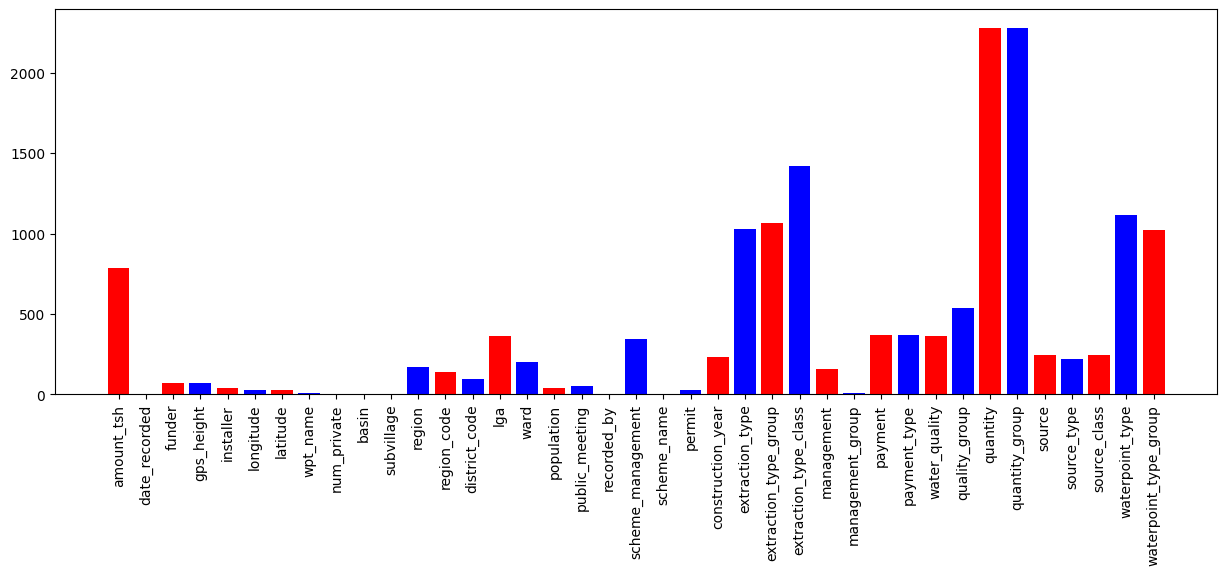

In [90]:
# Configuramos SelectKBest para usar la prueba ANOVA F-value como función de puntuación y seleccionar todas las características
fs = SelectKBest(score_func=f_classif, k='all')

# Ajustamos y transformamos los datos
fs.fit_transform(X=X_sel, y=y_sel)

# Obtenemos los nombres de las columnas seleccionadas
cols = X_sel.columns[fs.get_support(indices=True)].tolist()

# Creamos un gráfico de barras de los puntajes de las características
plt.subplots(figsize=(15, 5))
pyplot.bar(cols, fs.scores_, color=['red', 'blue'])
plt.xticks(rotation = 90)
pyplot.show()


#**II. Preprocesado de Datos**

###Transformamos 'date_recorded' en año, meses y días

In [91]:
#date time
df.date_recorded = pd.to_datetime(df.date_recorded)

In [92]:
df['year'] = df['date_recorded'].dt.year
df['month'] = df['date_recorded'].dt.month
df['day_of_months'] = df['date_recorded'].dt.day

In [93]:
df.drop(columns=['date_recorded'], axis=1, inplace=True)

### Unimos las siguientes características ya que son columnas redundantes

In [94]:
# Extraction
df["Extraction_all"] = df["extraction_type"] + df["extraction_type_group"] + df["extraction_type_class"]

#management
df["Management_all"] = df["management"] + df["management_group"]

#Payment
df["Payment_all"] = df["payment"] + df["payment_type"]

#quality
df["Quality_all"] = df["water_quality"] + df["quality_group"]

#Quantitiy
df["Quantity_all"] = df["quantity"] + df["quantity_group"]

#Source
df["Source_all"] = df["source"] + df["source_type"]

#waterpoint_type
df["Waterpoint_all"] = df["waterpoint_type"] + df["waterpoint_type_group"]

### Borramos las columnas que ya no son necesarias:
* extraction_type
* extraction_type_group
* extraction_type_class
* management
* management_group
* payment
* payment_type
* water_quality
* quality_group
* quantity
* quantity_group
* source
* source_type
* waterpoint_type
* waterpoint_type_group

In [95]:
# Borramos las columnas no necesarias
df.drop(columns=['extraction_type','extraction_type_group','extraction_type_class','management','management_group','payment','payment_type','water_quality','quality_group','quantity','quantity_group','source','source_type','waterpoint_type','waterpoint_type_group'], axis=1, inplace=True)

## **Normalización**

In [96]:
# Normalización Min Max
def normalize_minmax(joined_df, columns):
    result = joined_df.copy()
    for feature_name in columns:
        max_value = joined_df[feature_name].max()
        min_value = joined_df[feature_name].min()
        if max_value != min_value:  # Evitar la división por cero si todos los valores son iguales
            result[feature_name] = (joined_df[feature_name] - min_value) / (max_value - min_value)
        else:
            result[feature_name] = 0  # Opcionalmente, establecer en 0 o en otro valor predeterminado
    return result

In [97]:
# Normalizamos la columna 'amt' con Min Max
df=normalize_minmax(df,['amt'])

In [98]:
# La normalización por la media, también conocida como estandarización, ajusta los datos para que tengan una media de cero y una desviación estándar de uno.
def normalize_mean(df, columns):
    result = df.copy()
    for feature_name in columns:
        mean_value = df[feature_name].mean()
        std_value = df[feature_name].std()
        if std_value > 0:  # Comprobar si la desviación estándar no es cero
            result[feature_name] = (df[feature_name] - mean_value) / std_value
        else:  # Si la desviación estándar es cero, todos los valores son lo mismo, resultando en la varianza cero
            result[feature_name] = 0  # Opcional: Asignar cero o mantener los valores originales
    return result

In [99]:
# Normalizamos la columna 'population' con la media
df=normalize_mean(df,['population'])

##**One hot encoding**

One hot encoding es una técnica utilizada en el procesamiento de datos para convertir variables categóricas en un formato que puede ser proporcionado a los algoritmos de aprendizaje automático para hacer mejores predicciones. En la práctica, one hot encoding transforma cada categoría de una variable en una nueva variable binaria (0 o 1).

In [100]:
# Creamos la función de One Hot Encoding
def apply_one_hot_encoding(df, column, top_x_labels):
    for label in top_x_labels:
        new_col_name = f'{column}_{label}'
        df[new_col_name] = np.where(df[column] == label, 1, 0)
    return df

columns_to_encode = [
    "basin", "scheme_management", "Management_all", "Payment_all",
    "Quality_all", "Quantity_all", "Source_all", "Waterpoint_all"
]

for column in columns_to_encode:
    top_labels = df[column].value_counts().nlargest(25).index.tolist()
    print(f'Top labels for {column}: {top_labels}')
    df = apply_one_hot_encoding(df, column, top_labels)


Top labels for basin: ['Lake Victoria', 'Pangani', 'Rufiji', 'Internal', 'Lake Tanganyika', 'Wami / Ruvu', 'Lake Nyasa', 'Ruvuma / Southern Coast', 'Lake Rukwa']
Top labels for scheme_management: ['VWC', 'WUG', 'Water authority', 'WUA', 'Water Board', 'Parastatal', 'Company', 'Private operator', 'Other', 'SWC', 'Trust']
Top labels for Management_all: ['vwcuser-group', 'wuguser-group', 'water boarduser-group', 'wuauser-group', 'private operatorcommercial', 'parastatalparastatal', 'water authoritycommercial', 'otherother', 'companycommercial', 'unknownunknown', 'other - schoolother', 'trustcommercial']
Top labels for Payment_all: ['never paynever pay', 'pay per bucketper bucket', 'pay monthlymonthly', 'unknownunknown', 'pay when scheme failson failure', 'pay annuallyannually', 'otherother']
Top labels for Quality_all: ['softgood', 'saltysalty', 'unknownunknown', 'milkymilky', 'colouredcolored', 'salty abandonedsalty', 'fluoridefluoride', 'fluoride abandonedfluoride']
Top labels for Quant

In [101]:
for i in df.keys():
  i.replace('-', '_').replace('/', '_')
  print(i)

funder
gps_height
installer
longitude
latitude
basin
subvillage
region
region_code
district_code
lga
ward
population
public_meeting
scheme_management
permit
construction_year
source_class
amt
year
month
day_of_months
Extraction_all
Management_all
Payment_all
Quality_all
Quantity_all
Source_all
Waterpoint_all
basin_Lake Victoria
basin_Pangani
basin_Rufiji
basin_Internal
basin_Lake Tanganyika
basin_Wami / Ruvu
basin_Lake Nyasa
basin_Ruvuma / Southern Coast
basin_Lake Rukwa
scheme_management_VWC
scheme_management_WUG
scheme_management_Water authority
scheme_management_WUA
scheme_management_Water Board
scheme_management_Parastatal
scheme_management_Company
scheme_management_Private operator
scheme_management_Other
scheme_management_SWC
scheme_management_Trust
Management_all_vwcuser-group
Management_all_wuguser-group
Management_all_water boarduser-group
Management_all_wuauser-group
Management_all_private operatorcommercial
Management_all_parastatalparastatal
Management_all_water authorityco

In [102]:
# Después de aplicar la codificación one-hot a las columnas especificadas en nuestro DataFrame df,
# se procede a eliminar las columnas originales con df.drop. La razón principal para hacer esto es gestionar la dimensionalidad del DataFrame y evitar la redundancia.

df.drop(columns=["basin", "scheme_management", "Management_all", "Payment_all","Quality_all","Quantity_all","Source_all","Waterpoint_all"], axis=1, inplace=True)

###**Codificación ordinal**

La codificación ordinal, o "ordinal encoding", es una técnica utilizada en el preprocesamiento de datos para machine learning que convierte variables categóricas con un orden natural o jerárquico en valores numéricos. Esta técnica es especialmente útil cuando los atributos categóricos reflejan algún tipo de orden, como bajo, medio, alto; o primero, segundo, tercero, etc.

In [103]:
# Codificación ordinal
# Convertimos variables categóricas booleanas ('True' o 'False') en un formato numérico.
map = {
    False: 0,
    True: 1
  }

df['public_meeting'] = df['public_meeting'].map(map)

In [104]:
# Codificación ordinal
map = {
    False: 0,
    True: 1
  }

df['permit'] = df['permit'].map(map)

In [105]:
# Codificación ordinal
map = {
    'unknown': 0.845324,
    'surface': 0.791792,
    'groundwater': 0.855505
  }

df['source_class'] = df['source_class'].map(map)

###**Codificación binaria**

La codificación binaria es particularmente útil cuando el número de categorías únicas en las columnas es grande. Usando codificación binaria, las dimensiones aumentan logarítmicamente en lugar de linealmente (como sería con one-hot encoding). Esto puede reducir significativamente la cantidad de memoria utilizada si el número de categorías únicas es grande.

In [106]:
# Codificación binaria
# Aplicamos esta codificación cuando hay más de 15 valores únicos en alguna columna
# Se utiliza la biblioteca category_encoders
enc = ce.BinaryEncoder(cols=['funder','installer', 'subvillage', 'region','lga','ward','Extraction_all']).fit(df)
df = enc.transform(df)

In [107]:
combined2 = X.copy()
combined2['status_group'] = y['status_group']

In [108]:
# Label Encoding
combined2['status_group'] = LabelEncoder().fit_transform(combined2['status_group'])

In [109]:
encoder = TargetEncoder()
combined2['source_class_encoded'] = encoder.fit_transform(combined2['source_class'], combined2['status_group'])

In [110]:
combined2.loc[:,['source_class','source_class_encoded']].value_counts()

source_class  source_class_encoded
groundwater   0.855505                45794
surface       0.791792                13328
unknown       0.845324                  278
Name: count, dtype: int64

In [111]:
df.head()

,funder_0,funder_1,funder_2,funder_3,funder_4,funder_5,funder_6,funder_7,funder_8,funder_9,...,Source_all_damdam,Source_all_otherother,Source_all_unknownother,Waterpoint_all_communal standpipecommunal standpipe,Waterpoint_all_hand pumphand pump,Waterpoint_all_otherother,Waterpoint_all_communal standpipe multiplecommunal standpipe,Waterpoint_all_improved springimproved spring,Waterpoint_all_cattle troughcattle trough,Waterpoint_all_damdam
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,1,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,1,0,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,0,...,1,0,0,0,0,0,1,0,0,0
3,0,0,0,0,0,0,0,0,0,1,...,0,0,0,0,0,0,1,0,0,0
4,0,0,0,0,0,0,0,0,0,1,...,0,0,0,1,0,0,0,0,0,0


In [112]:
Y_copy = y.copy()

In [113]:
# Label Encoding
Y_copy['status_group'] = LabelEncoder().fit_transform(Y_copy['status_group'])

In [114]:
Y_copy.head()

,status_group
id,
69572,0
8776,0
34310,0
67743,2
19728,0


In [115]:
df.select_dtypes(include='O').keys()

Index([], dtype='object')

###**Separamos el dataset de training y entrenamiento**

In [116]:
X = df[:len(features_df)]
X_test = df[len(features_df):]

In [117]:
X.head()

,funder_0,funder_1,funder_2,funder_3,funder_4,funder_5,funder_6,funder_7,funder_8,funder_9,...,Source_all_damdam,Source_all_otherother,Source_all_unknownother,Waterpoint_all_communal standpipecommunal standpipe,Waterpoint_all_hand pumphand pump,Waterpoint_all_otherother,Waterpoint_all_communal standpipe multiplecommunal standpipe,Waterpoint_all_improved springimproved spring,Waterpoint_all_cattle troughcattle trough,Waterpoint_all_damdam
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,1,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,1,0,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,0,...,1,0,0,0,0,0,1,0,0,0
3,0,0,0,0,0,0,0,0,0,1,...,0,0,0,0,0,0,1,0,0,0
4,0,0,0,0,0,0,0,0,0,1,...,0,0,0,1,0,0,0,0,0,0


In [118]:
X_test.head()

,funder_0,funder_1,funder_2,funder_3,funder_4,funder_5,funder_6,funder_7,funder_8,funder_9,...,Source_all_damdam,Source_all_otherother,Source_all_unknownother,Waterpoint_all_communal standpipecommunal standpipe,Waterpoint_all_hand pumphand pump,Waterpoint_all_otherother,Waterpoint_all_communal standpipe multiplecommunal standpipe,Waterpoint_all_improved springimproved spring,Waterpoint_all_cattle troughcattle trough,Waterpoint_all_damdam
59400,0,0,0,0,1,0,1,0,0,0,...,0,0,0,0,0,1,0,0,0,0
59401,0,0,0,0,0,0,0,1,0,1,...,0,0,0,1,0,0,0,0,0,0
59402,0,0,0,0,0,0,0,1,0,1,...,0,0,0,0,0,1,0,0,0,0
59403,0,0,0,0,1,0,0,1,0,0,...,0,0,0,0,0,1,0,0,0,0
59404,0,1,0,0,0,0,0,0,1,1,...,0,0,0,1,0,0,0,0,0,0


In [119]:
X.shape

(59400, 151)

In [120]:
X_test.shape

(14850, 151)

##**Principle Components Analysis (PCA)**
Principle Components Analysis (PCA) es una técnica estadística de reducción de dimensiones ampliamente utilizada en el análisis de datos y en el machine learning. PCA transforma un conjunto de variables posiblemente correlacionadas en un conjunto de valores de variables linealmente no correlacionadas llamadas componentes principales. El proceso de PCA intenta capturar la mayor cantidad de información posible (en términos de varianza) con el menor número de componentes.

In [121]:
df_copy = df.copy()

In [122]:
y.head()

,status_group
id,
69572,functional
8776,functional
34310,functional
67743,non functional
19728,functional


In [123]:
pca = PCA(n_components=2)
X_pca = pca.fit_transform(X)
PCA_df = pd.DataFrame(data = X_pca, columns = ['PC1', 'PC2'])
PCA_df = pd.concat([PCA_df, Y_copy], axis = 1)
PCA_df.head()

,PC1,PC2,status_group
0,721.718506,-0.525901,2.0
1,730.616198,4.832210,0.0
2,17.641735,4.455249,0.0
3,-405.664767,91.289947,0.0
4,-668.336259,-3.675978,2.0


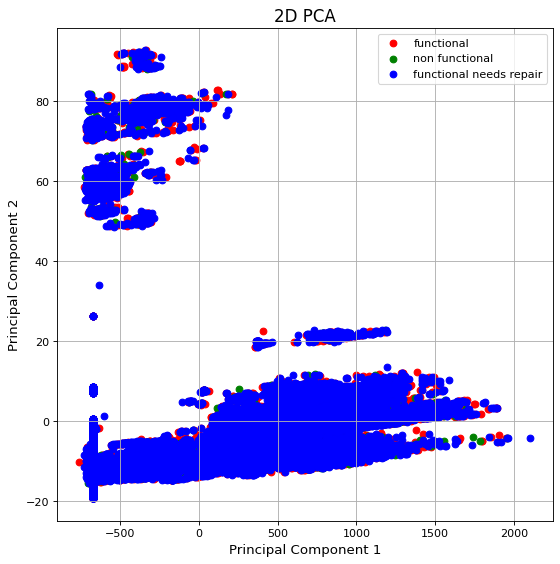

In [124]:
figure(num=None, figsize=(8, 8), dpi=80, facecolor='w', edgecolor='k')

classes = [2, 1, 0]
colors = ['r', 'g', 'b']
for clas, color in zip(classes, colors):
    plt.scatter(PCA_df.loc[PCA_df['status_group'] == clas, 'PC1'],
                PCA_df.loc[PCA_df['status_group'] == clas, 'PC2'],
                c = color)

plt.xlabel('Principal Component 1', fontsize = 12)
plt.ylabel('Principal Component 2', fontsize = 12)
plt.title('2D PCA', fontsize = 15)
plt.legend(['functional', 'non functional','functional needs repair'])
plt.grid()

En la gráfica los puntos azules (funcionales) son predominantes y están dispersos ampliamente, mientras que los puntos rojos y verdes están más agrupados y localizados en áreas específicas, sugiriendo que PCA está capturando una variación significativa relacionada con el estado de funcionamiento.

In [125]:
pca = PCA(n_components=2,svd_solver='full')
X_pca = pca.fit_transform(df_copy)
print(pca.explained_variance_)

[4.79950381e+05 3.47508092e+02]


In [126]:
print ( "Components = ", pca.n_components , ";\nTotal explained variance = ",
      round(pca.explained_variance_ratio_.sum(),5)  )

Components =  2 ;
Total explained variance =  0.99934


In [127]:
pca = PCA(n_components=2,svd_solver='full')
X_pca = pca.fit_transform(X)
print(pca.explained_variance_)

[4.80443006e+05 3.49825263e+02]


#**III. Entrenamiento del Modelo**

## **Modelos de Clasificación**

**RandomForestClassifier**

RandomForestClassifier es un modelo basado en ensamblaje que utiliza múltiples árboles de decisión para mejorar la precisión de clasificación y controlar el sobreajuste.

* *n_estimators=400* especifica que el modelo usará 400 árboles en el ensamble.
* *random_state=0* asegura que los resultados sean reproducibles al fijar la semilla para el generador de números aleatorios.
* *max_depth=20* limita la profundidad máxima de cada árbol a 20, lo que puede ayudar a evitar el sobreajuste.

In [128]:
# Importamos las bibliotecas necesarias
from sklearn.model_selection import RepeatedStratifiedKFold, cross_val_score
from numpy import mean, std
from sklearn.ensemble import RandomForestClassifier

# Configuramos la validación cruzada con 10 splits, repitiendo 3 veces y usando una semilla fija
cv = RepeatedStratifiedKFold(n_splits=10, n_repeats=3, random_state=0)


In [129]:
# Definimos el modelo
modelRF = RandomForestClassifier(n_estimators=400, random_state=0, max_depth=20)

In [130]:
# Calcula los scores de precisión (accuracy) mediante cross-validation
scores = cross_val_score(modelRF, X, y, scoring='accuracy', cv=cv, n_jobs=-1, error_score='raise')

# Imprime la media y la desviación estándar de los scores
print(f'Accuracy: {mean(scores):.3f} ({std(scores):.3f})')

Accuracy: 0.816 (0.004)


**ExtraTreesClassifier**

ExtraTreesClassifier es similar al RandomForest, pero crea árboles de una forma ligeramente diferente que puede dar mejores resultados en algunos conjuntos de datos.
* *n_estimators=1000* indica que se construirán 1000 árboles.
* *min_samples_split=10* establece el número mínimo de muestras requeridas para dividir un nodo interno en los árboles.

In [131]:
modelETC = ExtraTreesClassifier(n_estimators=1000,min_samples_split=10)

In [132]:
scores = cross_val_score(modelETC, X, y, scoring='accuracy', cv=cv, n_jobs=-1, error_score='raise')

# Imprime la media y la desviación estándar de los scores
print(f'Accuracy: {mean(scores):.3f} ({std(scores):.3f})')

Accuracy: 0.812 (0.004)


**XGBClassifier**:

XGBClassifier pertenece a la familia de modelos XGBoost, que es una implementación optimizada de gradient boosting.

Aquí se usa con parámetros predeterminados, pero XGBoost ofrece muchas opciones para ajustar el rendimiento y manejar el sobreajuste.

In [133]:
modelXGB = XGBClassifier()

In [134]:
# Modelo XGB
# Inicializamos LabelEncoder
label_encoder = LabelEncoder()

# Transformamos los valores categóricos a numéricos
y_encoded = label_encoder.fit_transform(y)

# Ahora y_encoded contiene valores enteros
scores = cross_val_score(modelXGB, X, y_encoded, scoring='accuracy', cv=cv, n_jobs=-1, error_score='raise')

# Imprime la media y la desviación estándar de los scores
print(f'Accuracy: {mean(scores):.3f} ({std(scores):.3f})')

Accuracy: 0.801 (0.004)


**CatBoostClassifier**

CatBoostClassifier es un algoritmo de boosting basado en árboles que maneja automáticamente las variables categóricas.

Los parámetros incluyen el número de iteraciones, la métrica de evaluación, la tasa de aprendizaje, entre otros. Por ejemplo, iterations=5000 establece el número de árboles a construir.

*eval_metric='AUC'*   indica que el modelo utilizará el área bajo la curva ROC como métrica de evaluación.


In [135]:
modelCAT = CatBoostClassifier(max_ctr_complexity=5, task_type='CPU', iterations=5000,
                   eval_metric='AUC', od_type='Iter', od_wait=500, loss_function = 'MultiClass', random_seed=1, depth=10, learning_rate = 0.03, l2_leaf_reg = 1)


In [151]:
scores = cross_val_score(modelCAT, X, y, scoring='accuracy', cv=cv, n_jobs=-1, error_score='raise')

# Imprime la media y la desviación estándar de los scores
print(f'Accuracy: {mean(scores):.3f} ({std(scores):.3f})')

KeyboardInterrupt: 

**MLPClassifier**

MLPClassifier representa un modelo de perceptrón multicapa, que es una forma de red neuronal artificial.



In [137]:
modelMLP = MLPClassifier()

In [138]:
scores = cross_val_score(modelMLP, X, y, scoring='accuracy', cv=cv, n_jobs=-1, error_score='raise')

# Imprime la media y la desviación estándar de los scores
print(f'Accuracy: {mean(scores):.3f} ({std(scores):.3f})')

Accuracy: 0.674 (0.066)


**SVC**

SVC implementa la Máquina de Vectores de Soporte (SVM), que es efectiva para problemas de clasificación de alto y bajo dimensional.

* *kernel='linear'* utiliza un kernel lineal, adecuado para datos linealmente separables.

* *C=1* establece el parámetro de regularización, que ayuda a equilibrar el margen de error y la complejidad del modelo.

* *gamma='auto'* ajusta el parámetro del kernel, en este caso seleccionado automáticamente basado en las características de los datos.

In [ ]:
#modelSVM = SVC(kernel='linear', C=1,gamma='auto')

In [ ]:
#scores = cross_val_score(modelSVM, X, y, scoring='accuracy', cv=cv, n_jobs=-1, error_score='raise')

# Imprime la media y la desviación estándar de los scores
# print(f'Accuracy: {mean(scores):.3f} ({std(scores):.3f})')

#**Ajuste de hiperparámetros**

In [139]:
def optimize_hyperparameters(model, params, X, y):
    """
    Optimiza los hiperparámetros de un modelo usando Grid Search.

    Args:
    model: instancia del modelo de machine learning
    params: diccionario de parámetros a probar
    X: datos de características
    y: datos objetivo

    Returns:
    Una tupla del mejor puntaje y los mejores parámetros encontrados.
    """
    grid_search = GridSearchCV(estimator=model, param_grid=params, cv=5, scoring='accuracy')
    grid_search.fit(X, y)
    return grid_search.best_score_, grid_search.best_params_

In [140]:
# Definición de parámetros para cada modelo
model_params = {
    'random_forest': {
        'model': RandomForestClassifier(),
        'params' : {
            'n_estimators': [50,100,200,400],
            'max_depth': [5, 10, 20, 100]
        }
    },
    'xg_boost': {
        'model': XGBClassifier(),
        'params' : {
            'eta': [0.01, 0.1, 0.2, 0.4],
            'max_depth': [5, 10, 15, 20, 22, 100]
        }
    },
    'cat_boost': {
        'model': CatBoostClassifier(loss_function = 'MultiClass', iterations=1000),
        'params' : {
            'learning_rate': [0.03, 0.1],
            'depth':[4, 6, 10],
            'l2_leaf_reg': [1, 3, 5, 7, 9]
        }
    }
}

In [141]:
X_tune=X
y_tune = y.status_group

In [142]:
# Ejemplo de cómo usar la función para optimizar RandomForest
best_score, best_params = optimize_hyperparameters(
    model_params['random_forest']['model'],
    model_params['random_forest']['params'],
    X_tune, y_tune
)

print("Mejor puntaje:", best_score)
print("Mejores parámetros:", best_params)

Mejor puntaje: 0.8140572390572391
Mejores parámetros: {'max_depth': 20, 'n_estimators': 400}


In [143]:
# Crear una instancia de LabelEncoder
encoder = LabelEncoder()

# Ajustar el codificador a las etiquetas categóricas y transformarlas en etiquetas numéricas
y_encoded = encoder.fit_transform(y_tune)

# Ahora se puede usar y_encoded en lugar de y_tune para grid search
best_score, best_params = optimize_hyperparameters(model_params['xg_boost']['model'], model_params['xg_boost']['params'], X_tune, y_encoded)
print("Mejor puntaje:", best_score)
print("Mejores parámetros:", best_params)


Mejor puntaje: 0.8093434343434343
Mejores parámetros: {'eta': 0.2, 'max_depth': 10}


In [152]:
# Optimización de hiperparámetros para el modelo CatBoost
best_score, best_params = optimize_hyperparameters(model_params['cat_boost']['model'], model_params['cat_boost']['params'], X_tune, y_tune)

# Imprimir los resultados de la optimización
print(f"Mejor puntuaje (CatBoost): {best_score}")
print(f"Mejores parámetros (CatBoost): {best_params}")


Se han truncado las últimas 5000 líneas del flujo de salida.
862:	learn: 0.5645589	total: 6.89s	remaining: 1.09s
863:	learn: 0.5644690	total: 6.9s	remaining: 1.09s
864:	learn: 0.5644244	total: 6.91s	remaining: 1.08s
865:	learn: 0.5643448	total: 6.92s	remaining: 1.07s
866:	learn: 0.5642790	total: 6.92s	remaining: 1.06s
867:	learn: 0.5642460	total: 6.93s	remaining: 1.05s
868:	learn: 0.5641983	total: 6.94s	remaining: 1.05s
869:	learn: 0.5641151	total: 6.95s	remaining: 1.04s
870:	learn: 0.5640427	total: 6.96s	remaining: 1.03s
871:	learn: 0.5639618	total: 6.96s	remaining: 1.02s
872:	learn: 0.5639160	total: 6.97s	remaining: 1.01s
873:	learn: 0.5638685	total: 6.98s	remaining: 1.01s
874:	learn: 0.5637988	total: 6.99s	remaining: 998ms
875:	learn: 0.5637612	total: 6.99s	remaining: 990ms
876:	learn: 0.5637130	total: 7s	remaining: 982ms
877:	learn: 0.5636640	total: 7.01s	remaining: 974ms
878:	learn: 0.5636336	total: 7.01s	remaining: 966ms
879:	learn: 0.5635844	total: 7.02s	remaining: 958ms
880:	le

KeyboardInterrupt: 

## **Entrenamos con el dataset completo**

In [145]:
model = modelRF
X_train = X
y_train = y

model.fit(X_train, y_train)

RandomForestClassifier(max_depth=20, n_estimators=400, random_state=0)

##**Predicción**

In [146]:
predict=model.predict(X_test)

In [147]:
!pip install gradio
!pip install joblib

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 12.3/12.3 MB 51.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 92.0/92.0 kB 14.4 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 315.9/315.9 kB 40.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 75.6/75.6 kB 12.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 142.5/142.5 kB 20.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 8.8/8.8 MB 108.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 47.2/47.2 kB 7.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 60.8/60.8 kB 10.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 129.9/129.9 kB 20.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 77.9/77.9 kB 12.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 58.3/58.3 kB 9.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 71.9/71.9 kB 11.6 M

In [148]:
import joblib

joblib.dump(model, 'random_forest_model.joblib')

['random_forest_model.joblib']

In [149]:
import gradio as gr
import joblib

# Cargar el modelo de Random Forest
model = joblib.load('random_forest_model.joblib')

# Definir la función de predicción que usa el modelo
def predict(longitude, latitude, gps_height, construction_year):
    prediction = model.predict([[longitude, latitude, gps_height, construction_year]])
    return prediction[0]

# Crear la interfaz de Gradio
def predict_gradio(longitude, latitude, gps_height, construction_year):
    return predict(longitude, latitude, gps_height, construction_year)

interface = gr.Interface(
    fn=predict_gradio,
    inputs=[
        gr.Number(label="Longitude", value=0),  # Cambiado de 'default' a 'value'
        gr.Number(label="Latitude", value=0),
        gr.Number(label="Gps_height", value=0),
        gr.Number(label="Construction_year", value=0)
    ],
    outputs="text",
    title="Random Forest Model Prediction",
    description="Enter the values for the four features to get a prediction from the model."
)

# Lanzar la interfaz
interface.launch()


Setting queue=True in a Colab notebook requires sharing enabled. Setting `share=True` (you can turn this off by setting `share=False` in `launch()` explicitly).

Colab notebook detected. To show errors in colab notebook, set debug=True in launch()
Running on public URL: https://a9bc6730a04ea9d083.gradio.live

This share link expires in 72 hours. For free permanent hosting and GPU upgrades, run `gradio deploy` from Terminal to deploy to Spaces (https://huggingface.co/spaces)


El siguiente código configura una figura, extrae la importancia de las características de un modelo de bosque aleatorio y visualiza las 15 características más importantes en un gráfico de barras horizontales.
Esto es muy útil en la selección de características y para entender mejor cómo el modelo está haciendo sus predicciones.

<Axes: >

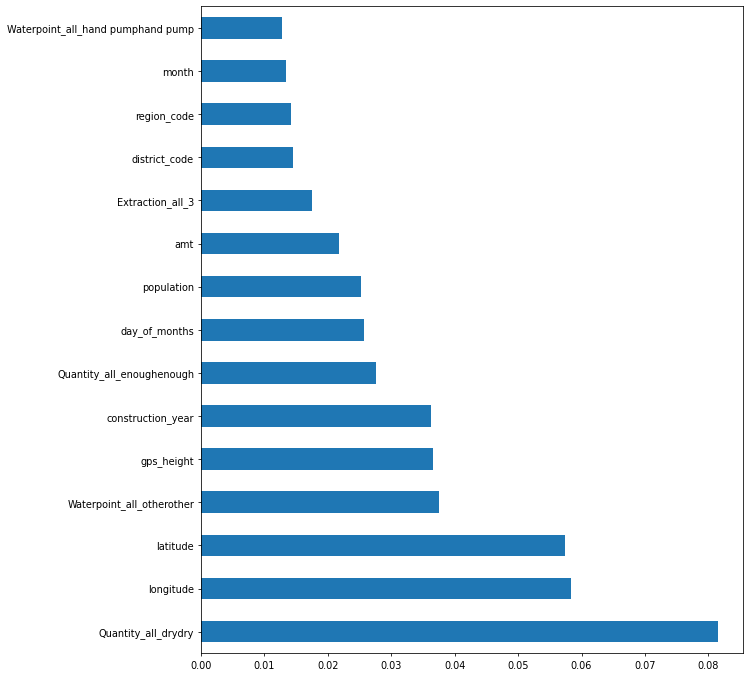

In [150]:
figure(num=None, figsize=(10, 12), dpi=70, facecolor='w', edgecolor='k')

# modelRF.feature_importances_: Es un array que contiene la importancia asignada a cada característica del modelo.
# Se muestra cuánto contribuye cada característica a la capacidad predictiva del modelo.
# index=X.columns: Asigna como índice de la serie los nombres de las columnas de X, que son las características usadas por el modelo.
feat_importances = pd.Series(modelRF.feature_importances_, index= X.columns)

#feat_importances.nlargest(15): Selecciona las 15 características más importantes de la serie.
feat_importances.nlargest(15).plot(kind='barh')